<center><h1>Policy prolongation for insurance company
<br>EDA + Classification</h1>
    



### **Data**


`«1»` – renewed,<br>
`«0»` - not renewed,

`80%` train data,<br>
`20%` test data. 

In [44]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np, math as mth, seaborn as sns, datetime as dt
from scipy import stats as st
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [ ]:
# from google.colab import files
# files.upload()

In [45]:
path = !pwd

In [46]:
df = pd.read_csv(path[0]+'/insurance data.csv', sep = ';')

In [ ]:
df.head()

### Step 2. Pre-processing and data preparation 

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96605 entries, 0 to 96604
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATA_TYPE                      96605 non-null  object 
 1   POLICY_ID                      96605 non-null  int64  
 2   POLICY_BEGIN_MONTH             96605 non-null  int64  
 3   POLICY_END_MONTH               96605 non-null  int64  
 4   POLICY_IS_RENEWED              96605 non-null  int64  
 5   POLICY_SALES_CHANNEL           96605 non-null  int64  
 6   POLICY_SALES_CHANNEL_GROUP     96605 non-null  int64  
 7   POLICY_BRANCH                  96605 non-null  object 
 8   POLICY_MIN_AGE                 96605 non-null  int64  
 9   POLICY_MIN_DRIVING_EXPERIENCE  96605 non-null  int64  
 10  VEHICLE_MAKE                   96605 non-null  object 
 11  VEHICLE_MODEL                  96605 non-null  object 
 12  VEHICLE_ENGINE_POWER           96605 non-null 

In [48]:
df.duplicated().sum()

0

In [49]:
df['POLICY_ID'].duplicated().sum()

0

In [50]:
df = df.drop(83392, inplace=False)

In [51]:
df.loc[df['VEHICLE_MAKE'] == 'Lada', 'VEHICLE_MAKE'] = 'ВАЗ'

In [52]:
df[df['VEHICLE_MAKE'] == 'Lada']

,DATA_TYPE,POLICY_ID,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,VEHICLE_MAKE,VEHICLE_MODEL,VEHICLE_ENGINE_POWER,VEHICLE_IN_CREDIT,VEHICLE_SUM_INSURED,POLICY_INTERMEDIARY,INSURER_GENDER,POLICY_CLM_N,POLICY_CLM_GLT_N,POLICY_PRV_CLM_N,POLICY_PRV_CLM_GLT_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_COURT_SIGN,CLAIM_AVG_ACC_ST_PRD,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,CLIENT_REGISTRATION_REGION,POLICY_PRICE_CHANGE


In [53]:
df.loc[df['VEHICLE_MODEL'].str.contains('Kalina'), 'VEHICLE_MODEL'] = 'Kalina'
df.loc[df['VEHICLE_MODEL'].str.contains('Priora'), 'VEHICLE_MODEL'] = 'Priora'

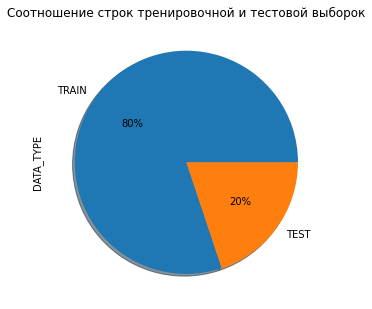

In [54]:
df['DATA_TYPE'].value_counts().plot(kind='pie',
                                    autopct='%1.0f%%',
                                    figsize=(5,6),
                                    shadow = True,title = 'Соотношение строк тренировочной и тестовой выборок')

Для дальнейшего анализа разделим данные на две таблицы.

In [55]:
df_train = df.query('DATA_TYPE == "TRAIN"')
df_test = df.query('DATA_TYPE != "TRAIN"')

Оценим корреляцию для выявления численных факторов, в наибольшей степени влияющих на целевую переменную. Это также пригодится в дальнейшем, при использовании алгоритма машинного обучения.

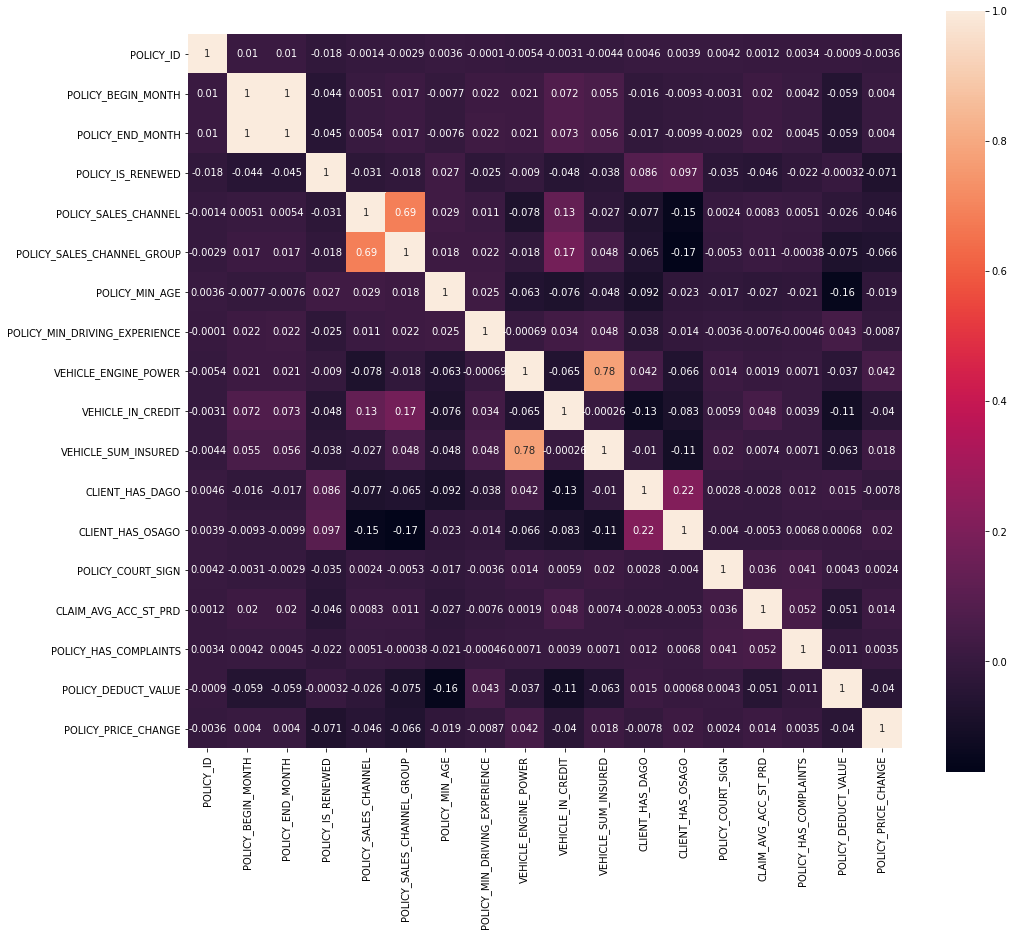

In [56]:
plt.figure(figsize=(16,14))
sns.heatmap(df_train.corr(), annot = True, square=True)

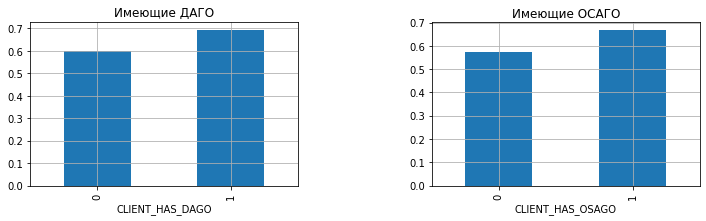

In [57]:
fig, ax = plt.subplots(1, 2, figsize = (12,3))
fig.subplots_adjust(wspace=0.5)

df_train.groupby('CLIENT_HAS_DAGO')['POLICY_IS_RENEWED'].mean().plot(kind='bar', ax =ax[0],
                                                                     grid=True, title='Имеющие ДАГО')

df_train.groupby('CLIENT_HAS_OSAGO')['POLICY_IS_RENEWED'].mean().plot(kind='bar', ax =ax[1],
                                                                      grid=True, title='Имеющие ОСАГО')
plt.show()

Действительно, среди тех, кто продлевает полис количество имеющих ДАГО и ОСАГО несколько больше, чем у тех кто не продлевает.

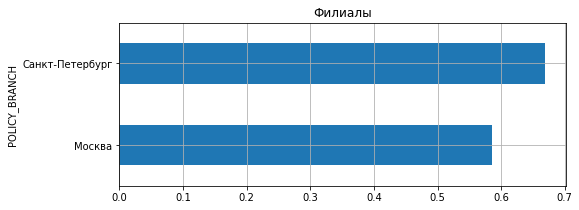

In [58]:
df_train.groupby('POLICY_BRANCH')['POLICY_IS_RENEWED'].mean().plot(kind='barh', grid=True,
                                                                   figsize=(8,3), title = 'Филиалы')

In [59]:
!pip install catboost

In [60]:
from catboost import CatBoostClassifier

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [62]:
df_original = df.copy() #на всякий случай

In [63]:
X_col = ['POLICY_SALES_CHANNEL_GROUP', 'POLICY_BRANCH', 'POLICY_MIN_AGE',
       'POLICY_MIN_DRIVING_EXPERIENCE', 'VEHICLE_MAKE', 'VEHICLE_MODEL',
       'VEHICLE_ENGINE_POWER', 'VEHICLE_IN_CREDIT', 'POLICY_INTERMEDIARY', 'INSURER_GENDER', 'POLICY_CLM_N',
       'POLICY_CLM_GLT_N', 'POLICY_PRV_CLM_N', 'POLICY_PRV_CLM_GLT_N',
       'CLIENT_HAS_DAGO', 'CLIENT_HAS_OSAGO', 'POLICY_COURT_SIGN',
       'CLAIM_AVG_ACC_ST_PRD', 'POLICY_HAS_COMPLAINTS',
       'POLICY_YEARS_RENEWED_N', 'POLICY_DEDUCT_VALUE',
       'CLIENT_REGISTRATION_REGION', 'POLICY_PRICE_CHANGE']

Y_col = ['POLICY_IS_RENEWED']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train[X_col], df_train[Y_col], test_size=0.2, random_state=42)

In [65]:
df_train.select_dtypes(include='object').columns

Index(['DATA_TYPE', 'POLICY_BRANCH', 'VEHICLE_MAKE', 'VEHICLE_MODEL',
       'POLICY_INTERMEDIARY', 'INSURER_GENDER', 'POLICY_CLM_N',
       'POLICY_CLM_GLT_N', 'POLICY_PRV_CLM_N', 'POLICY_PRV_CLM_GLT_N',
       'POLICY_YEARS_RENEWED_N', 'CLIENT_REGISTRATION_REGION'],
      dtype='object')

In [66]:
cat_features=['POLICY_BRANCH', 'VEHICLE_MAKE', 'VEHICLE_MODEL',
       'POLICY_INTERMEDIARY', 'INSURER_GENDER', 'POLICY_CLM_N',
       'POLICY_CLM_GLT_N', 'POLICY_PRV_CLM_N', 'POLICY_PRV_CLM_GLT_N',
       'POLICY_YEARS_RENEWED_N', 'CLIENT_REGISTRATION_REGION']

In [67]:
model = CatBoostClassifier(task_type="GPU")

In [68]:
model.fit(X_train, y_train, cat_features=cat_features, verbose=100)

Learning rate set to 0.026867
0:	learn: 0.6909143	total: 44.3ms	remaining: 44.3s
100:	learn: 0.6087729	total: 3.29s	remaining: 29.3s
200:	learn: 0.5892570	total: 6.38s	remaining: 25.4s
300:	learn: 0.5805049	total: 9.49s	remaining: 22s
400:	learn: 0.5750733	total: 12.6s	remaining: 18.9s
500:	learn: 0.5707058	total: 15.7s	remaining: 15.7s
600:	learn: 0.5672592	total: 18.8s	remaining: 12.5s
700:	learn: 0.5640080	total: 22.1s	remaining: 9.41s
800:	learn: 0.5613306	total: 25.2s	remaining: 6.25s
900:	learn: 0.5591844	total: 28.3s	remaining: 3.1s
999:	learn: 0.5571396	total: 31.3s	remaining: 0us


In [69]:
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [70]:
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]

In [71]:
metrics_report_lr=classification_report(y_test, predictions, output_dict=True)

In [72]:
classification_metrics=pd.DataFrame({'Metrics':['Accuracy:', 'Precision:','Recall:'],
              'Value':['{:.2f}'.format(
                  accuracy_score(y_test, predictions)),
                       '{:.2f}'.format(precision_score (y_test, predictions)),
                       '{:.2f}'.format(recall_score (y_test, predictions))]})

classification_metrics

,Metrics,Value
0,Accuracy:,0.72
1,Precision:,0.72
2,Recall:,0.90


In [73]:
from sklearn.metrics import roc_auc_score

In [74]:
roc_auc_score(y_test, probabilities)

0.7378269368618932

In [75]:
features = pd.DataFrame({'feature':df_train[X_col].columns,
                         'coeff': model.get_feature_importance()}).sort_values(by = 'coeff', ascending = False)
features

,feature,coeff
22,POLICY_PRICE_CHANGE,41.633650
8,POLICY_INTERMEDIARY,13.755981
5,VEHICLE_MODEL,7.744250
11,POLICY_CLM_GLT_N,6.343385
19,POLICY_YEARS_RENEWED_N,5.558268
21,CLIENT_REGISTRATION_REGION,4.841930
20,POLICY_DEDUCT_VALUE,4.205325
13,POLICY_PRV_CLM_GLT_N,2.743403
6,VEHICLE_ENGINE_POWER,2.275696
15,CLIENT_HAS_OSAGO,2.181171


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


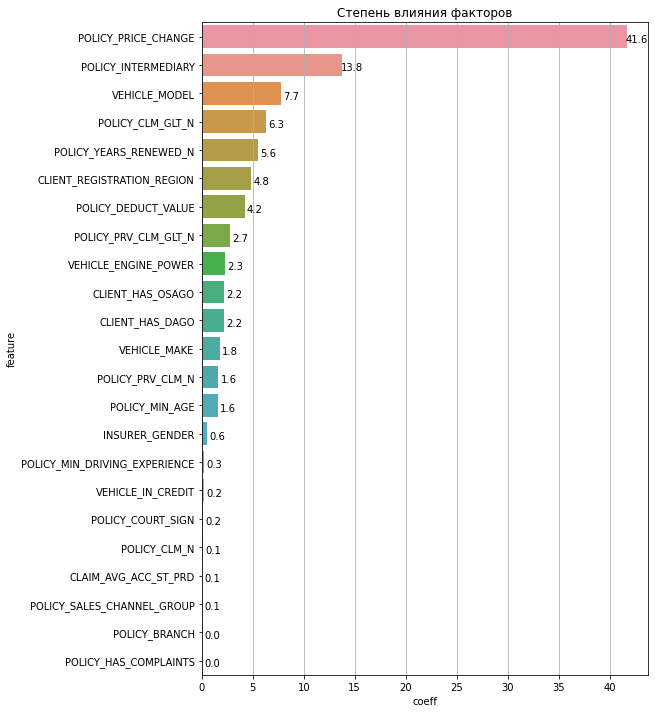

In [76]:
y = features['feature']
x = features['coeff']

plt.figure(figsize=(8,12))
plt.title('Степень влияния факторов')
plt.grid(True)

barlist2 = sns.barplot(x,y)

for p in barlist2.patches:
    width = p.get_width()
    barlist2.text(1 + width,
                  p.get_y()+p.get_height()/2. + 0.2,'{:1.1f}'.format(width),
                  ha="center")
plt.show()

In [77]:
predictions_train = model.predict(df_test[list(X_test.columns)])
probabilities_train = model.predict_proba(df_test[list(X_test.columns)])[:,1]

In [78]:
 df_result = pd.DataFrame({'POLICY_ID':df_test['POLICY_ID'],
                           'POLICY_IS_RENEWED':predictions_train,
                           'POLICY_IS_RENEWED_PROBABILITY':probabilities_train})
 df_result

,POLICY_ID,POLICY_IS_RENEWED,POLICY_IS_RENEWED_PROBABILITY
9,10,1,0.831549
11,12,1,0.699071
12,13,1,0.716230
21,22,0,0.249172
36,37,1,0.862789
...,...,...,...
96573,96574,1,0.825194
96576,96577,1,0.624329
96585,96586,1,0.865324
96594,96595,1,0.760701


In [79]:
df_result['POLICY_IS_RENEWED'].value_counts(normalize = True)

1    0.784457
0    0.215543
Name: POLICY_IS_RENEWED, dtype: float64